In [129]:
#packages
import pandas as pd
import numpy as np
import matplotlib as plt
import scipy

import warnings
import sqlite3

from numpy import asarray
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBRFRegressor
from shapely.geometry import Point, Polygon, shape


In [5]:
def create_connection(path):
    connection = None 
    connection = sqlite3.connect(path)
    connection.text_factory = str

    return connection

In [6]:
##Update this, its probably not where your DB is
con = create_connection('C:\\Data\\fire_data_v4.db\\fire_data_v5.db')

In [66]:
    cur = con.cursor()

    df = pd.read_sql('''
    select calls_for_service.analysis_neighborhoods as neighborhood
, calls_for_service.call_number
, calls_for_service.incident_number
, floating_catchment_output.[index]
, floating_catchment_output.zone_idx
, floating_catchment_output.accessibility_score
, floating_catchment_output.scenario_name
, calls_for_service.on_scene_dttm
, calls_for_service.response_dttm  
, fire_stations.facility_id
, fire_stations.latitude
, fire_stations.longitude
from floating_catchment_output
inner join zone_idx_to_incident on 
zone_idx_to_incident.zone_idx = floating_catchment_output.zone_idx
inner join calls_for_service on calls_for_service.incident_number = zone_idx_to_incident.incident_number
left join Truck_Engine_Fire_Station as tfs on tfs.unit = calls_for_service.unit_id
left join fire_stations on fire_stations.facility_id = tfs.facility_id
where calls_for_service.unit_type in ('TRUCK', 'ENGINE')
and scenario_name = 'baseline';''',con = con) 

In [67]:
#do some date math
df['on_scene_dttm'] = pd.to_datetime(df['on_scene_dttm'])
df['response_dttm'] = pd.to_datetime(df['response_dttm'])
df['arrival_time'] = (df['on_scene_dttm'] - df['response_dttm'])
df['minutes'] = (df.arrival_time.dt.seconds) / 60
df['seconds'] = (df.arrival_time.dt.seconds) 
df['day_of_week'] = df['on_scene_dttm'].dt.dayofweek
df['dayflag'] = (df.response_dttm.dt.hour > 5) & (df.response_dttm.dt.hour < 18)

df = df[df['dayflag'].notna()]
df = df[df['day_of_week'].notna()]
df = df[df['facility_id'].notna()]

In [68]:
import geopandas as gpd
print(df.count())

neighborhood           109998
call_number            110038
incident_number        110038
index                  110038
zone_idx               110038
accessibility_score    110038
scenario_name          110038
on_scene_dttm          110038
response_dttm          110038
facility_id            110038
latitude               110038
longitude              110038
arrival_time           110038
minutes                110038
seconds                110038
day_of_week            110038
dayflag                110038
dtype: int64


In [69]:
df_zones = pd.read_sql('''select zone_definitions.zone_idx, zone, floating_catchment_output.accessibility_score
from zone_definitions
inner join floating_catchment_output on zone_definitions.zone_idx = floating_catchment_output.zone_idx''', con)
df_zones['geometry'] = gpd.GeoSeries.from_wkt(df_zones['zone'])

df_stations = pd.read_sql('''
    SELECT DISTINCT latitude, longitude, facility_id FROM fire_stations''', con)
 
data_list = []
for lat,long,facility_id in zip(df_stations['latitude'], df_stations['longitude'], df_stations['facility_id']):    
    point = Point(long, lat)
    for zone, zone_accessibility_score, zone_idx in zip(df_zones["geometry"], df_zones["accessibility_score"], df_zones["zone_idx"]):
        polygon = Polygon(zone) 
 
        if point.within(polygon):
            data_list.append([facility_id, zone_idx, zone_accessibility_score]) 

zone_idx_mapping = pd.DataFrame(data_list, columns=('facility_id', 'station_zone_idx', 'zone_accessibility_score'))
zone_idx_mapping.head()


    

,facility_id,station_zone_idx,zone_accessibility_score
0,697,157,0.000086
1,707,192,0.000467
2,723,113,0.000804
3,692,167,0.000201
4,728,360,0.001506


In [70]:
df = df.merge(zone_idx_mapping, how="inner", on=["facility_id"])


In [71]:
df.head()

,neighborhood,call_number,incident_number,index,zone_idx,accessibility_score,scenario_name,on_scene_dttm,response_dttm,facility_id,latitude,longitude,arrival_time,minutes,seconds,day_of_week,dayflag,station_zone_idx,zone_accessibility_score
0,29.0,190012684,19000313,0,8,0.000803,baseline,2019-01-01 16:25:28,2019-01-01 16:22:21,716.0,37.779439,-122.502619,0 days 00:03:07,3.116667,187.0,1.0,True,28,0.000646
1,29.0,190022379,19000734,0,8,0.000803,baseline,2019-01-02 15:35:57,2019-01-02 15:31:21,716.0,37.779439,-122.502619,0 days 00:04:36,4.600000,276.0,2.0,True,28,0.000646
2,29.0,190053013,19002138,0,8,0.000803,baseline,2019-01-05 20:41:37,2019-01-05 20:40:16,716.0,37.779439,-122.502619,0 days 00:01:21,1.350000,81.0,5.0,False,28,0.000646
3,29.0,190060098,19002211,0,8,0.000803,baseline,2019-01-06 00:54:34,2019-01-06 00:52:49,716.0,37.779439,-122.502619,0 days 00:01:45,1.750000,105.0,6.0,False,28,0.000646
4,29.0,190123355,19005074,0,8,0.000803,baseline,2019-01-12 19:47:03,2019-01-12 19:45:02,716.0,37.779439,-122.502619,0 days 00:02:01,2.016667,121.0,5.0,False,28,0.000646


In [72]:
#rool up accessibility and minutes to zone
df_ag = df.groupby(["facility_id", "day_of_week", "dayflag", "zone_idx", "station_zone_idx"], as_index=False).agg({"accessibility_score":"mean", "zone_accessibility_score":"mean", "minutes":"mean"})
print(len(df_ag))
df_ag.head()

11400


,facility_id,day_of_week,dayflag,zone_idx,station_zone_idx,accessibility_score,zone_accessibility_score,minutes
0,691.0,0.0,False,235,288,0.000769,0.000103,3.008333
1,691.0,0.0,False,247,288,0.000245,0.000103,2.880000
2,691.0,0.0,False,248,288,0.000167,0.000103,3.594444
3,691.0,0.0,False,249,288,0.000320,0.000103,4.823810
4,691.0,0.0,False,266,288,0.000191,0.000103,18.816667


In [126]:
# hide the warings.
# I mean if it was really important it would just be an error, so blissfully ignore
warnings.filterwarnings('ignore')

# set the training variables
df_ag.target_to_predict = 'minutes'
df_ag.predictors = ['station_zone_idx', 'day_of_week', 'dayflag', 'accessibility_score', 'zone_accessibility_score']


df_ag.x = df_ag[df_ag.predictors].values
df_ag.y = df_ag[df_ag.target_to_predict].values

df_ag.x_train, df_ag.x_test, df_ag.y_train, df_ag.y_test = train_test_split(df_ag.x, df_ag.y, test_size=0.8, random_state=42)


In [127]:
#copy/paste code:
import matplotlib.pyplot as plt
from xgboost import plot_tree

def create_model(md):
    #RegModel = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=500, objective='reg:linear', booster='gbtree')
    md.model = XGBRFRegressor(n_estimators=300, subsample=0.5, colsample_bynode=0.8, min_child_weight=3)

    #Printing all the parameters of XGBoost
    print(md.model)
    
    #Creating the model on Training Data
    md.XGB = md.model.fit(md.x_train, md.y_train)
    
    prediction = md.XGB.predict(md.x_test)

    #Measuring Goodness of fit in Training data
    print('R2 Value:', metrics.r2_score(md.y_train, md.XGB.predict(md.x_train)))

    #Measuring accuracy on Testing Data
    print('md.ytest', md.y_test)
    print('Accuracy', 100 - (np.mean(np.abs((md.y_test - prediction)) / np.mean(md.y_test)) * 100))
    print('Accuracy', 100 - (np.mean(np.abs((md.y_test - prediction) / md.y_test)) * 100))

    #Plotting the feature importance for Top 10 most important columns 
    %matplotlib inline
    feature_importances = pd.Series(md.XGB.feature_importances_, index = md.predictors)
    feature_importances.nlargest(10).plot(kind = 'barh')
    
    fig, ax = plt.subplots(figsize=(100, 100))
    plot_tree(md.model, ax=ax,rankdir='LR', fmap='feature_map.txt')
    plt.show()


XGBRFRegressor(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bytree=None, enable_categorical=False, gamma=None,
               gpu_id=None, importance_type=None, interaction_constraints=None,
               max_delta_step=None, max_depth=None, min_child_weight=3,
               missing=nan, monotone_constraints=None, n_estimators=300,
               n_jobs=None, num_parallel_tree=None,
               objective='reg:squarederror', predictor=None, random_state=None,
               reg_alpha=None, scale_pos_weight=None, subsample=0.5,
               tree_method=None, validate_parameters=None, verbosity=None)
R2 Value: 0.18728898423581675
md.ytest [2.40238095 4.72380952 2.75       ... 5.40833333 4.53333333 3.26521739]
Accuracy 59.1717099758639
Accuracy -inf


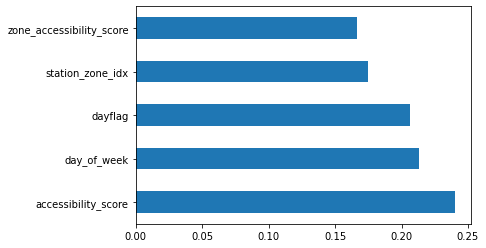

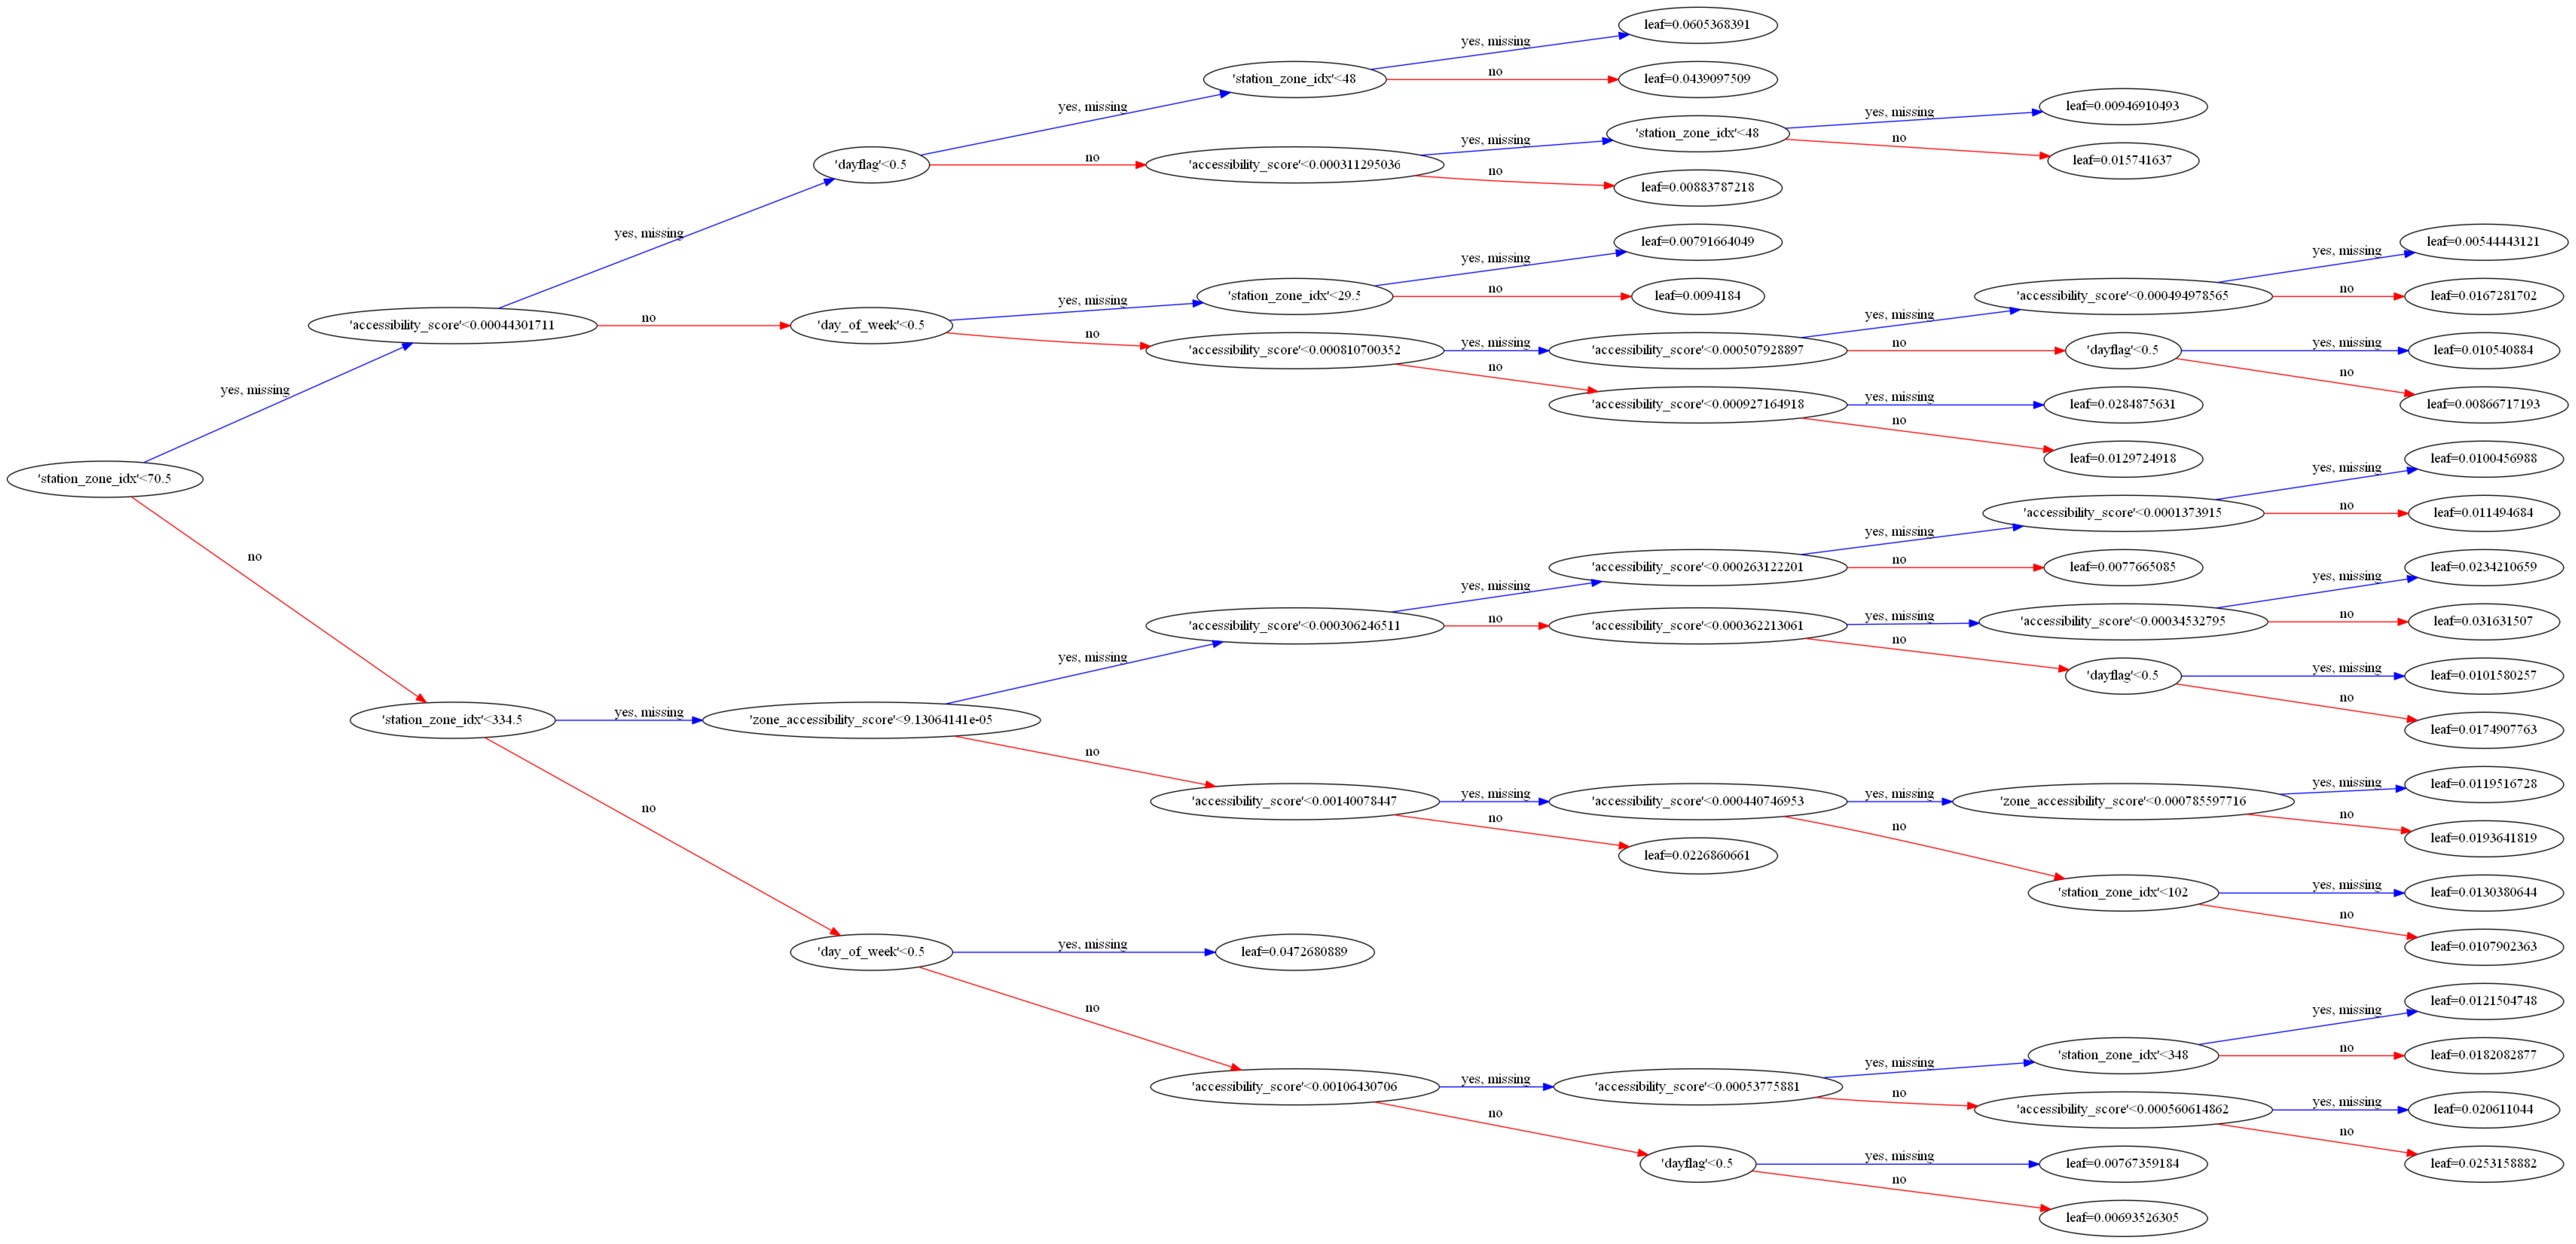

In [128]:
create_model(df_ag)

In [91]:
cur = con.cursor()
df_scenarios = pd.read_sql(('select distinct scenario_name from simulation_floating_catchment_output limit 2'), con=con)


In [94]:
prediction_stats = []
predictions = []
compare_errors = []

for i in range(len(df_scenarios)):
    #Get data to predict
    cur = con.cursor()
    scenario_name = df_scenarios["scenario_name"][i]
    day_of_week = 3
    dayFlag = True
    sql = '''select distinct fire_station_zones.facility_id, accessibility_score 
, ? as day_of_week, ? as dayflag 
from simulation_floating_catchment_output 
inner join (select distinct
floating_catchment_output.zone_idx 
, fire_stations.facility_id
from floating_catchment_output
inner join zone_idx_to_incident on 
zone_idx_to_incident.zone_idx = floating_catchment_output.zone_idx
inner join calls_for_service on calls_for_service.incident_number = zone_idx_to_incident.incident_number
left join Truck_Engine_Fire_Station as tfs on tfs.unit = calls_for_service.unit_id
left join fire_stations on fire_stations.facility_id = tfs.facility_id
where calls_for_service.unit_type in ('TRUCK', 'ENGINE')
and scenario_name = 'baseline') as fire_station_zones 
    on fire_station_zones.zone_idx = simulation_floating_catchment_output.zone_idx
where scenario_name = ?'''
    df_to_predict = pd.read_sql((sql), con=con,params=[day_of_week, dayFlag, scenario_name])
    #assumptions
    df_to_predict["dayflag"] = dayFlag
    df_to_predict["day_of_week"] = day_of_week
    print("Predicting: " + scenario_name + ", records:" + str(df_to_predict.count()))
    
    df_to_predict = df_to_predict.merge(zone_idx_mapping, how="inner", on=["facility_id"])
    
    df_to_predict = df_to_predict.rename(columns={"station_zone_idx": "zone_idx"})
    
    prediction = df_ag.XGB.predict(df_to_predict[["zone_accessibility_score", "zone_idx", "accessibility_score", "day_of_week", "dayflag"]])
    print(prediction)
    
    print(len(prediction))
    df_to_predict['predicted_minutes'] = prediction.copy()

    compare_error = df_ag.merge(df_to_predict, how="inner", on=["zone_idx", "day_of_week","dayflag"])

    compare_error["minutes_delta"] = compare_error["minutes"] - compare_error["predicted_minutes"]
    compare_error["accessibility_delta"] = (compare_error["accessibility_score_x"] - compare_error["accessibility_score_y"])
    compare_error['scenario_name'] = scenario_name
    
    compare_errors.append(compare_error.copy())
    sq_error_sum = np.sum(np.square(np.array(compare_error["minutes"]) - np.array(compare_error["predicted_minutes"])))
    sq_error_mean = np.sum(np.square(np.average(compare_error["minutes"]) - np.array(compare_error["minutes"])))

    (r, p) = scipy.stats.pearsonr(compare_error["minutes_delta"], compare_error["accessibility_delta"])

    prediction_stats.append((scenario_name, sq_error_sum.copy(), sq_error_mean.copy(), r,p))
    df_to_predict["scenario_name"] = scenario_name
    predictions.append(df_to_predict.copy())
    
    




Predicting: new_station_235, records:facility_id            1731
accessibility_score    1765
day_of_week            1765
dayflag                1765
dtype: int64
[5.2942266 5.2942266 5.2942266 ... 5.2942266 5.2942266 5.2942266]
1694


AttributeError: 'XGBRFRegressor' object has no attribute 'plot_tree'

In [32]:
print(pd.concat(compare_errors)[['minutes_delta', 'accessibility_delta', 'scenario_name', 'zone_idx']].to_csv('delta_analysis_dayflag_original_parameters.csv'))

KeyError: "['zone_idx'] not in index"

In [17]:
sts = pd.DataFrame(prediction_stats)
sts = sts.rename(columns={0: "scenario_name", 1: "sq_avg_error", 2:"sq_sum_error", 3:"r_value",4:"p_value"}, errors="raise")

sts.to_csv('prediction_stats.csv')


In [93]:
pd.concat(predictions).to_csv('predictions_facilityId_station_accessibility.csv')

In [19]:
df_ag.to_csv('aggregated_facilityId.csv')